In [2]:
import pandas as pd
import requests
import numpy as np
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          90 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.20.0-py_0 conda-forge


geopy-1.20.0         | 57 KB     | ##################################### | 100% 
geographiclib-1.49   | 

### Get geographical location of each city

In [3]:
toronto = 'Totonto, ON'
newyork = 'New York City, NY'
london = 'London, UK'
hongkong = 'Hong Kong, HK'
cities = [toronto, newyork, london, hongkong]
df_city = pd.DataFrame(np.zeros([4,2]),index = cities, columns = ['lat','lon'])
df_city

,lat,lon
"Totonto, ON",0.0,0.0
"New York City, NY",0.0,0.0
"London, UK",0.0,0.0
"Hong Kong, HK",0.0,0.0


In [4]:
gg = Nominatim(user_agent = 'my_application')
loc_to = gg.geocode('Toronto, ON')[1]
loc_ny = gg.geocode('New York City, NY')[1]
loc_ld = gg.geocode('London, UK')[1]
loc_hk = gg.geocode('Hong Kong')[1]
for city,loc in zip(cities,[loc_to,loc_ny,loc_ld,loc_hk]):
    df_city.loc[city,'lat']= loc[0]
    df_city.loc[city,'lon'] = loc[1]
    print('The geograpical coordinate of {} are {}, {}.'.format(city,loc[0], loc[1]))

The geograpical coordinate of Totonto, ON are 43.653963, -79.387207.
The geograpical coordinate of New York City, NY are 40.7127281, -74.0060152.
The geograpical coordinate of London, UK are 51.4893335, -0.144055084527687.
The geograpical coordinate of Hong Kong, HK are 22.2793278, 114.1628131.


In [5]:
# create map of New York using latitude and longitude values
map1 = folium.Map(location=[loc_to[0], 0], zoom_start=3)

# add markers to map
for lat, lng, city in zip(df_city['lat'], df_city['lon'], df_city.index):
    label = folium.Popup(city, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map1)  


### Query FourSquare Data

In [6]:
CLIENT_ID = 'W1MU50VYTMFRD4YBFNZYA2TTXJ2IMZYT50I5SEHDBK3IFUB4' # your Foursquare ID
CLIENT_SECRET = '2ETX5YBIJONHC00N13402CXJJZXKVGFQ5FSZ3KFMNWKQMJEV' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 500
radius = 3000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: W1MU50VYTMFRD4YBFNZYA2TTXJ2IMZYT50I5SEHDBK3IFUB4
CLIENT_SECRET:2ETX5YBIJONHC00N13402CXJJZXKVGFQ5FSZ3KFMNWKQMJEV


In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=3000, LIMIT = 500):
    venues_list=[]
    for name, lat, lon in zip(names, latitudes, longitudes):
        #print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lon, 
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lon, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['shortName']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [8]:
df_nei = getNearbyVenues(df_city.index,df_city.lat,df_city.lon)

In [9]:
df_nei.iloc[[1,101,201,301],:]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,"Totonto, ON",43.653963,-79.387207,Art Gallery of Ontario,43.654003,-79.392922,Art Gallery
101,"New York City, NY",40.712728,-74.006015,The Beekman - A Thompson Hotel,40.711173,-74.006702,Hotel
201,"London, UK",51.489334,-0.144055,Apollo Victoria Theatre,51.495622,-0.142689,Theater
301,"Hong Kong, HK",22.279328,114.162813,Hong Kong Park Aviary (香港公園觀鳥園),22.277140,114.161399,Zoo


In [10]:
df_dummy = pd.get_dummies(df_nei['Venue Category'])
df_dummy['City'] = df_nei['Neighborhood']
col = [df_dummy.columns[-1]] + list(df_dummy.columns[:-1])
df_dummy = df_dummy.loc[:,col]
df_dummy.head()

,City,American,Apparel,Aquarium,Argentinian,Art Gallery,Art Museum,Arts & Crafts,Asian,Athletics & Sports,...,Train Station,Udon,Vegetarian / Vegan,Vietnamese,Volleyball Court,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,"Totonto, ON",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Totonto, ON",0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Totonto, ON",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Totonto, ON",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Totonto, ON",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df_cate = df_dummy.groupby('City').sum()

### Use Hierarchical Clustering Method

In [12]:
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 

In [13]:
dist_matrix = distance_matrix(df_cate,df_cate) 
print(dist_matrix)

[[ 0.         16.673332   17.49285568 16.73320053]
 [16.673332    0.         19.54482029 20.68816087]
 [17.49285568 19.54482029  0.         14.83239697]
 [16.73320053 20.68816087 14.83239697  0.        ]]


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:351: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='weighted', metric='euclidean')


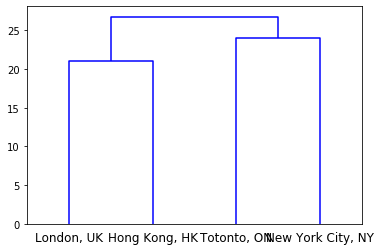

In [16]:
Z = hierarchy.weighted(dist_matrix)
den = hierarchy.dendrogram(Z,  labels = cities)

In [17]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [18]:
map2 = folium.Map(location=[loc_to[0], 0], zoom_start=3)
clu = [0,0,1,1]

##create color map
colors_array = cm.rainbow(np.linspace(0, 1, 2))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, city,color in zip(df_city['lat'], df_city['lon'], df_city.index,clu):
    label = folium.Popup(city, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[color],
        fill=True,
        fill_color=rainbow[color],
        fill_opacity=0.7,
        parse_html=False).add_to(map2)  
map2

As we could see from above dendrogram and distance matrix, the most 2 close cities are London and Hong Kong, which is kind of reasonable as Hong Kong has been colonized by Britain for more than 100 years, so their venue categories around the downtown should be very similar as well. Another category is Toronto and New York, it is also reasonable to find that they are very similar because they are close both geographically and culturally, how they build their venues should be similar as well.

## Define Major Venue Features in Toronto
As I can't find suitable neighborhood dataset in Hong Kong and London, therefore, I will only use neighborhoods in Toronto to find major venue categories.
In other words, I will cluster neighborhoods in Toronto and New York into several major types according to venues in the neighborhood.

### Cluster Neighborhoods in Toronto

#### Collect Data and Clean it
Extract neighborhood data from both wikipedia('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M') and existing resource.

In [20]:
!conda install -c conda-forge beautifulsoup4 --yes
from bs4 import BeautifulSoup
!conda install -c conda-forge lxml --yes
import lxml

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    soupsieve-1.9.3            |           py36_0          57 KB  conda-forge
    beautifulsoup4-4.8.0       |           py36_0         144 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         201 KB

The following NEW packages will be INSTALLED:

    soupsieve:      1.9.3-py36_0 conda-forge

The following packages will be UPDATED:

    beautifulsoup4: 4.6.3-py37_0             --> 4.8.0-py36_0 conda-forge


soupsieve-1.9.3     

In [21]:
res = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

soup = BeautifulSoup(res.content,'html5lib')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))[0]

In [22]:
## delete borough Not Assigned and only use Borough = Downtwon Toronto
df = df.loc[~(df['Borough'] == 'Not assigned'),:]
df = df.loc[df.Borough == 'Downtown Toronto',:]
df.index = np.arange(len(df))
df.head()

,Postcode,Borough,Neighbourhood
0,M5A,Downtown Toronto,Harbourfront
1,M5A,Downtown Toronto,Regent Park
2,M5B,Downtown Toronto,Ryerson
3,M5B,Downtown Toronto,Garden District
4,M5C,Downtown Toronto,St. James Town


In [23]:
##combine postal code
df_combine_neigh = df.groupby('Postcode')['Neighbourhood'].apply(lambda x: "%s" % ', '.join(x))
df_combine_neigh = pd.DataFrame(df_combine_neigh)
df_combine_neigh['Borough'] = df.groupby('Postcode')['Borough'].first()
df_combine_neigh['PostalCode'] = df_combine_neigh.index
df_combine_neigh.index = np.arange(len(df_combine_neigh))
df_combine_neigh = df_combine_neigh[['PostalCode','Borough','Neighbourhood']]
df_combine_neigh.head()

,PostalCode,Borough,Neighbourhood
0,M4W,Downtown Toronto,Rosedale
1,M4X,Downtown Toronto,"Cabbagetown, St. James Town"
2,M4Y,Downtown Toronto,Church and Wellesley
3,M5A,Downtown Toronto,"Harbourfront, Regent Park"
4,M5B,Downtown Toronto,"Ryerson, Garden District"


In [24]:
##read coordinate data
coordinate = pd.read_csv('https://cocl.us/Geospatial_data')
df = pd.merge(df,coordinate,how = 'inner',left_on = 'Postcode',right_on = 'Postal Code')
df.drop('Postal Code',axis = 1,inplace = True)
df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
1,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
2,M5B,Downtown Toronto,Ryerson,43.657162,-79.378937
3,M5B,Downtown Toronto,Garden District,43.657162,-79.378937
4,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418


In [68]:
nearby_venues = getNearbyVenues(df.Neighbourhood, df.Latitude, df.Longitude, radius=500, LIMIT = 100)
nearby_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Harbourfront,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Harbourfront,43.65426,-79.360636,Toronto Cooper Koo Family Cherry St YMCA Centre,43.653191,-79.357947,Gym / Fitness
3,Harbourfront,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,Harbourfront,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast


In [69]:
nearby_venues.iloc[[0,1,51,101,200],:]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Harbourfront,43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
51,Regent Park,43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
101,Regent Park,43.654260,-79.360636,GW General,43.650495,-79.357538,Antiques
200,Ryerson,43.657162,-79.378937,Shisha&Co,43.656748,-79.374337,Smoke Shop


In [70]:
nearby_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adelaide,100,100,100,100,100,100
Bathurst Quay,16,16,16,16,16,16
Berczy Park,57,57,57,57,57,57
CN Tower,16,16,16,16,16,16
Cabbagetown,48,48,48,48,48,48


Text(0, 0.5, 'Venue Number')

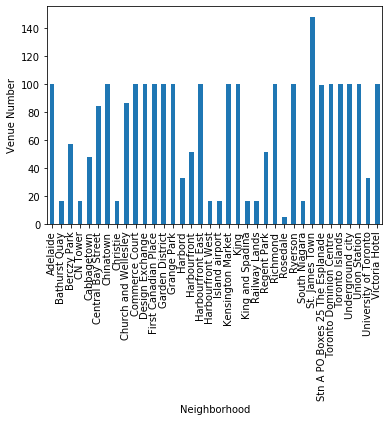

In [71]:
import matplotlib.pyplot as plt
nearby_venues.groupby('Neighborhood').count()['Venue'].plot(kind = 'bar')
plt.ylabel('Venue Number')

In [72]:
neigh_venue = pd.get_dummies(nearby_venues[['Venue Category']])
neigh_venue['neighborhood'] = nearby_venues['Neighborhood']
col = [neigh_venue.columns[-1]] +  list(neigh_venue.columns[:-1])
neigh_venue = neigh_venue[col]
neigh_venue.head()

,neighborhood,Venue Category_Afghan,Venue Category_Airport,Venue Category_Airport Service,Venue Category_American,Venue Category_Antiques,Venue Category_Apparel,Venue Category_Aquarium,Venue Category_Art Gallery,Venue Category_Art Museum,...,Venue Category_Toys & Games,Venue Category_Trail,Venue Category_Train Station,Venue Category_Travel,Venue Category_Vegetarian / Vegan,Venue Category_Video Games,Venue Category_Vietnamese,Venue Category_Wine Bar,Venue Category_Wings,Venue Category_Yoga Studio
0,Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
neigh_venue_to = neigh_venue.groupby('neighborhood').sum()

### Use K-Means Cluster

Text(0, 0.5, 'Mean Distance within clusters')

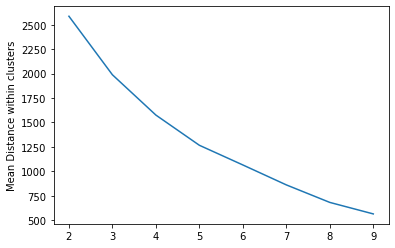

In [74]:
#neighborhoods_venues_sorted.drop('neighborhood',1,inplace = True)
from sklearn.cluster import KMeans
score = []
for n_cluster in range(2,10):
    model = KMeans(n_init = 50, random_state = 7, n_clusters = n_cluster)
    model.fit(neigh_venue_to)
    score.append(-model.score(neigh_venue_to))
    
import matplotlib.pyplot as plt
plt.plot(np.arange(2,10),score)
plt.ylabel('Mean Distance within clusters')

As I can't find clear elbow point in this case, I will use n_clusters = 3 to do analysis 

In [75]:
model = KMeans(n_init = 50, random_state = 7, n_clusters = 3)
model.fit(neigh_venue_to)
neigh_venue_to['labels'] = model.labels_

In [76]:
neigh_venue_to_label = neigh_venue_to[[neigh_venue_to.columns[-1]] + list(neigh_venue_to.columns[:-1])]
neigh_venue_to_label_group = neigh_venue_to_label.groupby('labels').mean()
neigh_venue_to_label_group

,Venue Category_Afghan,Venue Category_Airport,Venue Category_Airport Service,Venue Category_American,Venue Category_Antiques,Venue Category_Apparel,Venue Category_Aquarium,Venue Category_Art Gallery,Venue Category_Art Museum,Venue Category_Arts,...,Venue Category_Toys & Games,Venue Category_Trail,Venue Category_Train Station,Venue Category_Travel,Venue Category_Vegetarian / Vegan,Venue Category_Video Games,Venue Category_Vietnamese,Venue Category_Wine Bar,Venue Category_Wings,Venue Category_Yoga Studio
labels,,,,,,,,,,,,,,,,,,,,,
0,0.0000,0.0000,0.000,2.058824,0.058824,1.352941,0.882353,1.0000,0.235294,0.000,...,0.117647,0.0000,0.411765,0.529412,1.117647,0.117647,0.117647,0.882353,0.0000,0.058824
1,0.0625,0.4375,0.875,0.125000,0.125000,0.062500,0.000000,0.1875,0.000000,0.125,...,0.000000,0.0625,0.000000,0.000000,0.062500,0.187500,0.062500,0.000000,0.0625,0.187500
2,0.0000,0.0000,0.000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000,...,0.000000,0.0000,0.000000,0.000000,6.000000,0.000000,4.000000,1.000000,0.0000,0.000000


In [77]:
##show 10 most frequent venues in each class
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['class']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['class'] = [0,1,2]

for ind in np.arange(3):
    row = neigh_venue_to_label_group.iloc[ind,:].sort_values(ascending = False)[:num_top_venues]
    neighborhoods_venues_sorted.iloc[ind, 1:] = row.index

In [78]:
neighborhoods_venues_sorted

,class,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Venue Category_Coffee Shop,Venue Category_Café,Venue Category_Hotel,Venue Category_Restaurant,Venue Category_Italian,Venue Category_Bar,Venue Category_Steakhouse,Venue Category_Bakery,Venue Category_American,Venue Category_Pizza
1,1,Venue Category_Coffee Shop,Venue Category_Café,Venue Category_Restaurant,Venue Category_Lounge,Venue Category_Bakery,Venue Category_Airport Service,Venue Category_Terminal,Venue Category_Park,Venue Category_Bar,Venue Category_Pub
2,2,Venue Category_Café,Venue Category_Vegetarian / Vegan,Venue Category_Bar,Venue Category_Chinese,Venue Category_Dumplings,Venue Category_Vietnamese,Venue Category_Bakery,Venue Category_Mexican,Venue Category_Coffee Shop,Venue Category_Burgers


## Conclusion
Even though we may find that these 3 classes are pretty similar as cafe, coffee and restaurants are very common in all these venues, it's still reasonable as food venue is always the most popular one in all neighborhoods, and it's easies to open compared with museum or gym. Fortunately, we can still extract some difference from these 3 classes.
1. As the first 5 venues are all relevant to food and drinks, so the first class should be 'pure food and drinks';
2. As Park is the 3rd most common venue, so the second class should be 'Entertainment and food';
3. While Hotel is the 3rd common venue in the 3rd class, so it should be 'Vacation and Leisure'.

In [79]:
venue_class_latlng = nearby_venues.groupby('Neighborhood').first().iloc[:,:3]
venue_class_latlng['labels'] = model.labels_
venue_class_latlng.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,labels
Neighborhood,,,,
Adelaide,43.650571,-79.384568,Four Seasons Centre for the Performing Arts,0
Bathurst Quay,43.628947,-79.394420,Billy Bishop Toronto City Airport (YTZ) (Billy...,1
Berczy Park,43.644771,-79.373306,LCBO,1
CN Tower,43.628947,-79.394420,Billy Bishop Toronto City Airport (YTZ) (Billy...,1
Cabbagetown,43.667967,-79.367675,Cranberries,1


In [80]:
map3 = folium.Map(location=[loc_to[0], loc_to[1]], zoom_start=12)

##create color map
colors_array = cm.rainbow(np.linspace(0, 1, 3))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, nei,color in zip(venue_class_latlng['Neighborhood Latitude'], venue_class_latlng['Neighborhood Longitude'], venue_class_latlng.index,venue_class_latlng['labels']):
    label = folium.Popup(nei, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[color],
        fill=True,
        fill_color=rainbow[color],
        fill_opacity=0.7,
        parse_html=False).add_to(map3)  
map3